In [31]:
from math import ceil
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from basis_expansions import NaturalCubicSpline
from dftransformers import (ColumnSelector, Identity,
                            FeatureUnion, MapFeature,
                            Intercept)
from regression_helpers import (plot_univariate_smooth,
                                bootstrap_train,
                                display_coef,
                                plot_bootstrap_coefs,
                                plot_partial_depenence,
                                plot_partial_dependences,
                                predicteds_vs_actuals)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Linear Regression Assumptions and Inference

We discussed, at the end of the first lecture on linear regression, that regression could be used for *inference*, and we quickly dicussed the p-values that are reported from a regression.

Let's now go back to that topic, and see what additional assumptions and checks we must make to use linear regression in this way.

## The Linear Regression Assumptions

Linear regression is often presented along with a list of assumptions.

#### The Linear Regression Assumptions:
  - Linearity
  - Linear Independence
  - Independence
  - Homoskedacity
  - Normal Distribution of Errors
  
These assumptions are not all needed, nor must they all be checked, for all applications of linear regression.  Indeed, when used as a **predictive** model, only the first is really needed (though some of the others bear consequences when blatantly violated).

We will take these assumptions in turn, and discuss what the assumption means, and what can happen when it is violated.

#### Example

We will continue to use the running example from this morning on concrete compressive strength.

In [3]:
concrete = pd.read_excel('Concrete_Data.xls')

column_names = [
    'cement',
    'blast_furnace_slag',
    'fly_ash',
    'water',
    'superplasticizer',
    'coarse_aggregate',
    'finite_aggregate',
    'age',
    'compressive_strength',
]
concrete.columns = column_names

In [5]:
cement_fit = Pipeline([
    ('cement', ColumnSelector(name='cement')),
    ('cement_spline', NaturalCubicSpline(knots=[200, 300, 400]))
])

age_fit = Pipeline([
    ('age', ColumnSelector(name='age')),
    ('finite_add_spline', NaturalCubicSpline(knots=[20, 50, 100, 150]))
])

slag_fit = Pipeline([
    ('slag', ColumnSelector(name='blast_furnace_slag')),
    ('slag_features', FeatureUnion([
        ('zero_slag', MapFeature(lambda slag: slag == 0.0, 'zero_slag')),
        ('slag_spline', NaturalCubicSpline(knots=[35, 60, 150, 200, 250]) )  
    ]))
])

fly_ash_fit = Pipeline([
    ('fly_ash', ColumnSelector(name='fly_ash')),
    ('fly_ash_features', FeatureUnion([
        ('zero_fly_ash', MapFeature(lambda ash: ash == 0.0, 'zero_fly_ash')),
        ('twenty_five_fly_ash', MapFeature(
            lambda ash: (ash >= 24.0) & (ash <= 26.0), 'twenty_five_fly_ash')),
        ('fly_ash', NaturalCubicSpline(knots=[100, 125, 150]))  
    ]))
])

water_fit = Pipeline([
    ('water', ColumnSelector(name='water')),
    ('water_spline', NaturalCubicSpline(knots=[170, 190, 210]))
])

superplasticizer_fit = Pipeline([
    ('superplasticizer', ColumnSelector(name='superplasticizer')),
    ('superplasticizer_features', FeatureUnion([
        ('zero_superplasticizer', 
            MapFeature(lambda plast: plast == 0.0, 'zero_superplasticizer')),
        ('superplasticizer_spline', 
            NaturalCubicSpline(knots=[5, 10, 15]) )  
    ]))
])

coarse_agg_fit = Pipeline([
    ('coarse_agg', ColumnSelector(name='coarse_aggregate')),
    ('course_add_spline', NaturalCubicSpline(knots=[900, 975, 1050]))
])

finite_agg_fit = Pipeline([
    ('finite_agg', ColumnSelector(name='finite_aggregate')),
    ('finite_add_spline', NaturalCubicSpline(knots=[900, 975, 1050]))
])

In [6]:
feature_pipeline = FeatureUnion([
    ('intercept', Intercept()),
    ('cement_fit', cement_fit),
    ('slag_fit', slag_fit),
    ('fly_ash_fit', fly_ash_fit),
    ('water_fit', water_fit),
    ("superplasticizer_fit", superplasticizer_fit),
    ("coarse_agg_fit", coarse_agg_fit),
    ("finite_agg_fit", finite_agg_fit),
    ("age_fit", age_fit)
])

In [7]:
feature_pipeline.fit(concrete)
features = feature_pipeline.transform(concrete)

## The Linearity Assumption

Recall that the "linear" in the name "linear regression" does **not** mean that the model is attempting to fit a linear function of the **raw features**.  Instead, it means that the model is a linear function of the **transformed features**.

So, the **linearity assumption** in regression says that the **model fits the data well**.  I.e., that $y$ is a **linear function of the (possibly transformed) features in the model**.  Of course, $y$ cannot be an exact linear function, because there is some randomness involved, but this should be the **only reason** that $y$ is not a linear function of the features.

$$ y = \beta_0 + \beta_1 f_1 + \beta_2 f_2 + \cdots + \beta_k f_k + \text{noise} $$

The residuals vs. feature plots we looked at in the morning can be used to assess violation of this assumption.

Suppose we create some data in which a feature enters in a non-linear manner, but then we fit to the data without using the proper feature transformations.

In [29]:
x = np.random.uniform(-2, 4, size=500)
y = 1 + x - 0.5 * x * x + np.random.normal(size=500)

model = LinearRegression()
model.fit(x.reshape(-1, 1), y)

y_hat = model.predict(x.reshape(-1, 1))

In [30]:
def residual_plot(ax, x, y, y_hat, n_bins=50):
    residuals = y - y_hat
    ax.axhline(0, color="black", linestyle="--")
    ax.scatter(x, residuals, color="grey", alpha=0.5)
    ax.set_ylabel("Residuals ($y - \hat y$)")

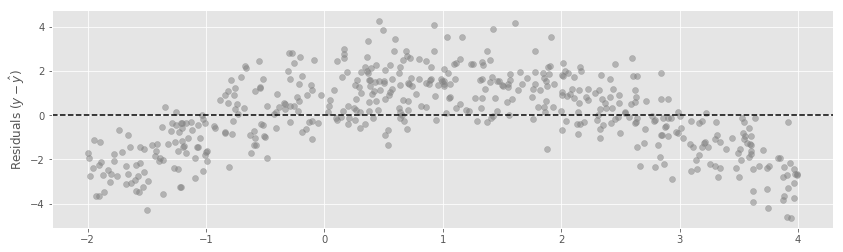

In [31]:
fig, ax = plt.subplots(figsize=(14, 4))
residual_plot(ax, x, y, y_hat)

We clearly do not have a band evenly spaced around the center line. This type of plot indicates that something is missing from the model.

By fitting a transformation of the predictor, we can recapture the nice residuals.

## Consistency: The Independence Assumption

In [20]:
def plot_regressions(ax, n, num=50):
    for k in range(num):
        x = np.random.uniform(-1, 1, size=n)
        y = 2*x + np.random.normal(0.0, 1.0, size=n)
        if k == 0:
            ax.scatter(x, y, color="grey")
        model = LinearRegression()
        model.fit(x.reshape(-1, 1), y)
        t = np.linspace(-1, 1, num=250)
        ax.plot(t, model.predict(t.reshape(-1, 1)), color="grey", alpha=0.5)

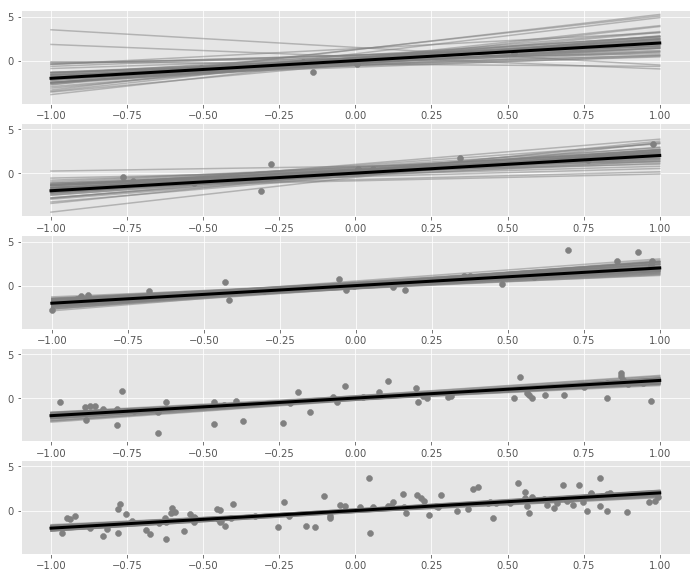

In [21]:
ns = [5, 10, 25, 50, 100]

fig, axs = plt.subplots(len(ns), figsize=(12, 10), sharey=True)
for ax, n in zip(axs, ns):
    plot_regressions(ax, n)
    ax.plot([-1, 1], [-2, 2], color="black", linewidth=3)

## Normality of Errors: Distribution of Parameter Estimates

In [49]:
def run_one_regression(n):
    x1 = np.random.uniform(-1, 1, size=n)
    x2 = np.random.uniform(-0.5, 0.5, size=n)
    x3 = np.random.uniform(-2, 2, size=n)
    y = 1 + x1 - 2*x2 + np.random.normal(size=n)
    X = np.empty(shape=(n, 3))
    X[:, 0] = x1; X[:, 1] = x2; X[:, 2] = x3
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_

def simulate_many_coeffs(n, n_sim=50000):
    coeffs = np.empty(shape=(n_sim, 3))
    for i in range(n_sim):
        coeffs[i, :] = run_one_regression(n)
    return coeffs

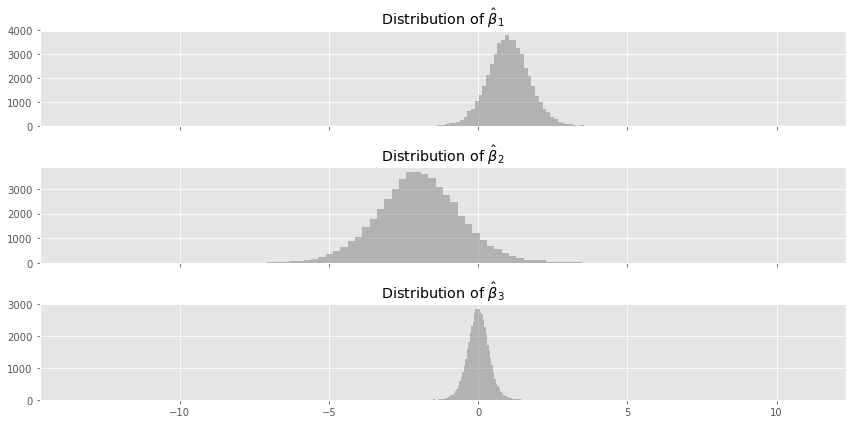

In [50]:
fig, axs = plt.subplots(3, figsize=(12, 6), sharex=True)

coeffs = simulate_many_coeffs(10)
axs[0].hist(coeffs[:, 0], bins=100, color="grey", alpha=0.5)
axs[0].set_title(r"Distribution of $\hat \beta_1$")
axs[1].hist(coeffs[:, 1], bins=100, color="grey", alpha=0.5)
axs[1].set_title(r"Distribution of $\hat \beta_2$")
axs[2].hist(coeffs[:, 2], bins=100, color="grey", alpha=0.5)
axs[2].set_title(r"Distribution of $\hat \beta_3$")

fig.tight_layout()